<a href="https://colab.research.google.com/github/carloscotrini/transformers_from_scratch/blob/main/AML_MiniUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import random

SHAPES = ["triangle", "circle"]
PLURALS = [shape + "s" for shape in SHAPES]
ARTICLES = ["a", "one"]
TWO_ARTICLES = ["two"]
CONNECTORS = ["and", "then"]
REVERSE_CONNECTORS = ["after"]
CLASS_TOKEN = "CLS"
MASK_TOKEN = "MASK"
SEP_TOKEN = "SEP"
PAD_TOKEN = "PAD"
EOS_TOKEN = "EOS"
SPECIAL_TOKENS = [CLASS_TOKEN, MASK_TOKEN, SEP_TOKEN, PAD_TOKEN, EOS_TOKEN]
VOCABULARY = SHAPES + PLURALS + ARTICLES + CONNECTORS + REVERSE_CONNECTORS + TWO_ARTICLES + SPECIAL_TOKENS
MAX_LEN_SENTENCE = 16 # Maximum possible length of a sequence

def generate_random_shapes():
  num_shapes = random.randint(1, 4)
  result = []
  for _ in range(num_shapes):
    result.append(random.choice(SHAPES))
  return result

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

def generate_image(word_list, filename, mask_filename):
    # Create a blank 32x32 image
    image_size = 32
    patch_size = 16
    image = Image.new("1", (image_size, image_size), 1)  # '1' for 1-bit pixels, black and white
    mask = Image.new("1", (image_size, image_size), 1)

    for i, word in enumerate(word_list):
        if word not in ["triangle", "circle"]:
            continue

        # Determine the top-left corner of the patch
        x_offset = (i % 2) * patch_size
        y_offset = (i // 2) * patch_size

        # Draw the shape in the corresponding patch
        draw = ImageDraw.Draw(image)
        draw_mask = ImageDraw.Draw(mask)
        if word == "triangle":
            points = [(random.randint(x_offset, x_offset + patch_size), random.randint(y_offset, y_offset + patch_size)) for _ in range(3)]
            draw.polygon(points, fill=0)
            draw_mask.polygon(points, fill=0)
        elif word == "circle":
            radius = random.randint(2, patch_size // 2)
            center_x = random.randint(x_offset + radius, x_offset + patch_size - radius)
            center_y = random.randint(y_offset + radius, y_offset + patch_size - radius)
            draw.ellipse([center_x - radius, center_y - radius, center_x + radius, center_y + radius], fill=0)

    # Save the image to the specified filename
    image.save(filename)
    mask.save(mask_filename)

def plot_image(filename):
    # Open the image
    image = Image.open(filename)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage:
generate_image(["circle", "triangle", "circle"], "output_image.png", "masked_output_image.png")

In [11]:
def generate_data(n_samples):
  examples = []
  for i in range(n_samples):
    shape_list = generate_random_shapes()
    filename = f"f{i}.png"
    mask_filename = f"m{i}.png"
    generate_image(shape_list, filename, mask_filename)
    examples.append({"shape_list": shape_list, "filename": filename, "mask_filename": mask_filename})
  return examples

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [17]:
class FigureDataset(Dataset):
    def __init__(self, n_samples, image_dir=".", transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.examples = generate_data(n_samples)
        self.image_files = [e["filename"] for e in self.examples]
        self.mask_files = [e["mask_filename"] for e in self.examples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.image_files[idx])
        mask_name = os.path.join(self.image_dir, self.mask_files[idx])
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [18]:
# Define the U-Net model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(1, 4)
        self.enc2 = CBR(4, 8)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.center = CBR(8, 16)

        self.up2 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.dec2 = CBR(16, 8)
        self.up1 = nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2)
        self.dec1 = CBR(8, 4)

        self.final = nn.Conv2d(4, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))

        center = self.center(self.pool(enc2))

        dec2 = self.dec2(torch.cat([self.up2(center), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1))

        return torch.sigmoid(self.final(dec1))

In [19]:
from tqdm import tqdm

# Training settings
batch_size = 4
num_epochs = 20
learning_rate = 0.001

transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset and split into training and testing sets
dataset = FigureDataset(
    n_samples=200,
    image_dir=".",
    transform=transform
)

train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training complete.")

100%|██████████| 40/40 [00:00<00:00, 43.30it/s]


Epoch [1/20], Loss: 0.7673


100%|██████████| 40/40 [00:00<00:00, 52.71it/s]


Epoch [2/20], Loss: 0.6773


100%|██████████| 40/40 [00:00<00:00, 54.90it/s]


Epoch [3/20], Loss: 0.6147


100%|██████████| 40/40 [00:00<00:00, 56.75it/s]


Epoch [4/20], Loss: 0.5605


100%|██████████| 40/40 [00:00<00:00, 81.89it/s]


Epoch [5/20], Loss: 0.5114


100%|██████████| 40/40 [00:00<00:00, 80.67it/s]


Epoch [6/20], Loss: 0.4651


100%|██████████| 40/40 [00:00<00:00, 78.07it/s]


Epoch [7/20], Loss: 0.4223


100%|██████████| 40/40 [00:00<00:00, 78.37it/s]


Epoch [8/20], Loss: 0.3815


100%|██████████| 40/40 [00:00<00:00, 76.86it/s]


Epoch [9/20], Loss: 0.3437


100%|██████████| 40/40 [00:00<00:00, 80.10it/s]


Epoch [10/20], Loss: 0.3072


100%|██████████| 40/40 [00:00<00:00, 79.85it/s]


Epoch [11/20], Loss: 0.2746


100%|██████████| 40/40 [00:00<00:00, 78.79it/s]


Epoch [12/20], Loss: 0.2428


100%|██████████| 40/40 [00:00<00:00, 81.87it/s]


Epoch [13/20], Loss: 0.2151


100%|██████████| 40/40 [00:00<00:00, 80.93it/s]


Epoch [14/20], Loss: 0.1828


100%|██████████| 40/40 [00:00<00:00, 82.15it/s]


Epoch [15/20], Loss: 0.1554


100%|██████████| 40/40 [00:00<00:00, 78.52it/s]


Epoch [16/20], Loss: 0.1285


100%|██████████| 40/40 [00:00<00:00, 80.55it/s]


Epoch [17/20], Loss: 0.1124


100%|██████████| 40/40 [00:00<00:00, 79.20it/s]


Epoch [18/20], Loss: 0.0953


100%|██████████| 40/40 [00:00<00:00, 80.09it/s]


Epoch [19/20], Loss: 0.0839


100%|██████████| 40/40 [00:00<00:00, 76.86it/s]

Epoch [20/20], Loss: 0.0742
Training complete.


In [20]:
# Testing loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

100%|██████████| 10/10 [00:00<00:00, 69.93it/s]

Test Loss: 0.0678


In [21]:
import matplotlib.pyplot as plt
import torch

# Function to plot image, true mask, and predicted mask
def plot_image_mask_prediction(image, true_mask, predicted_mask):
    plt.figure(figsize=(15, 5))

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot the true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

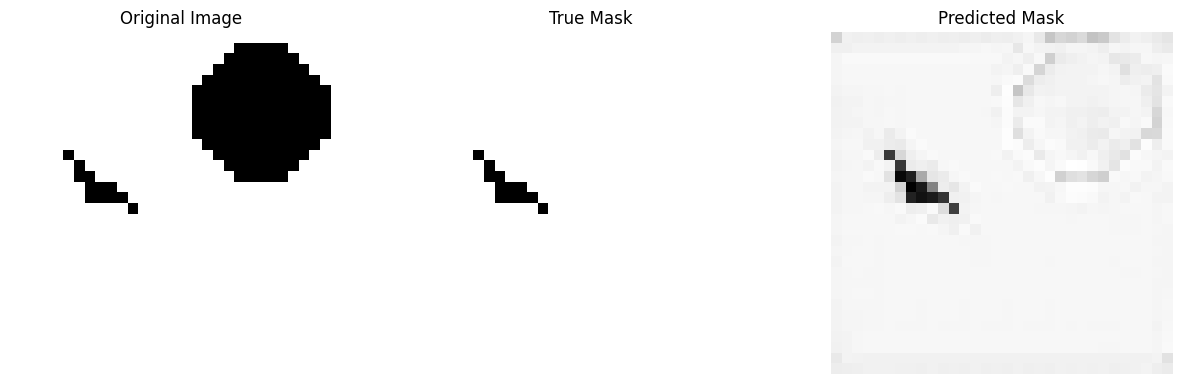

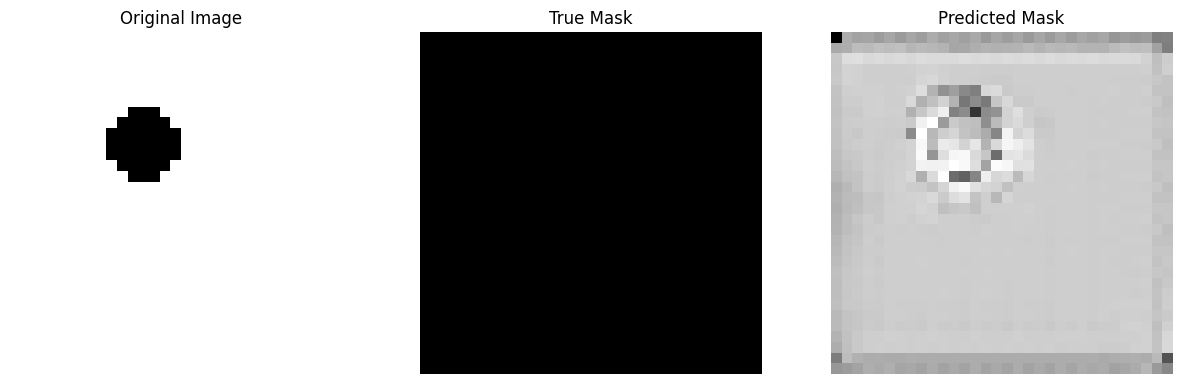

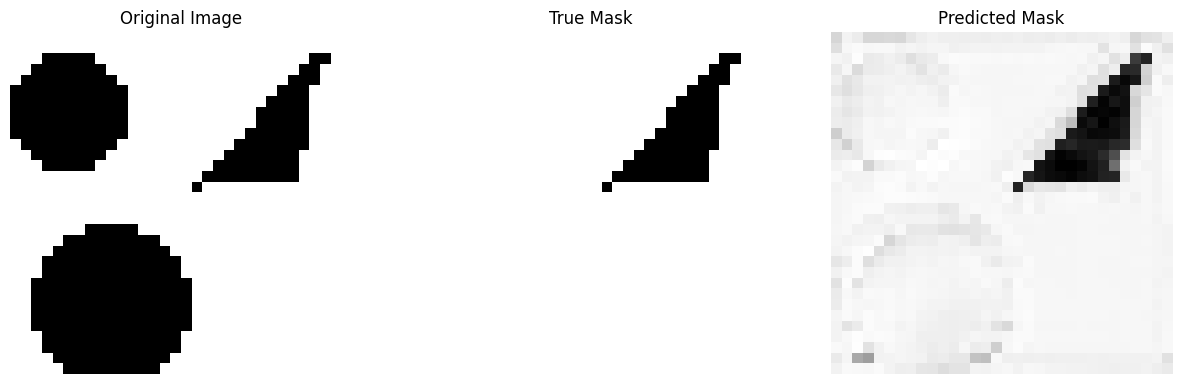

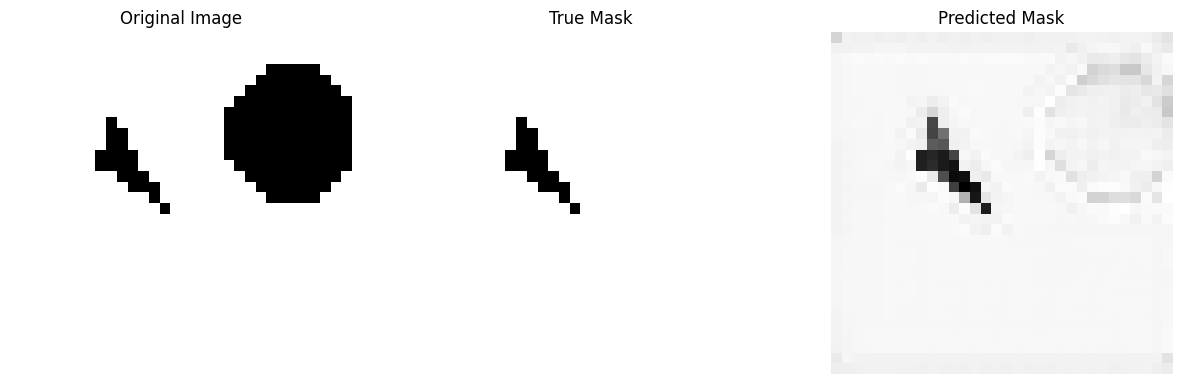

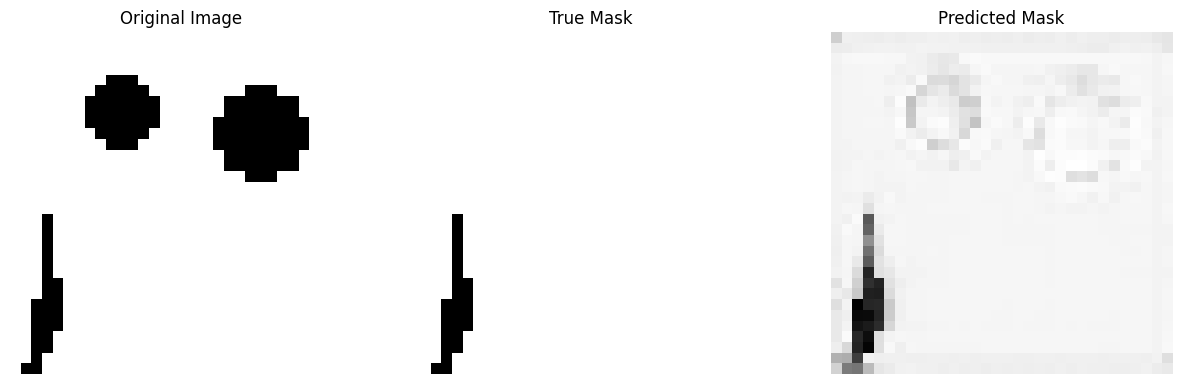

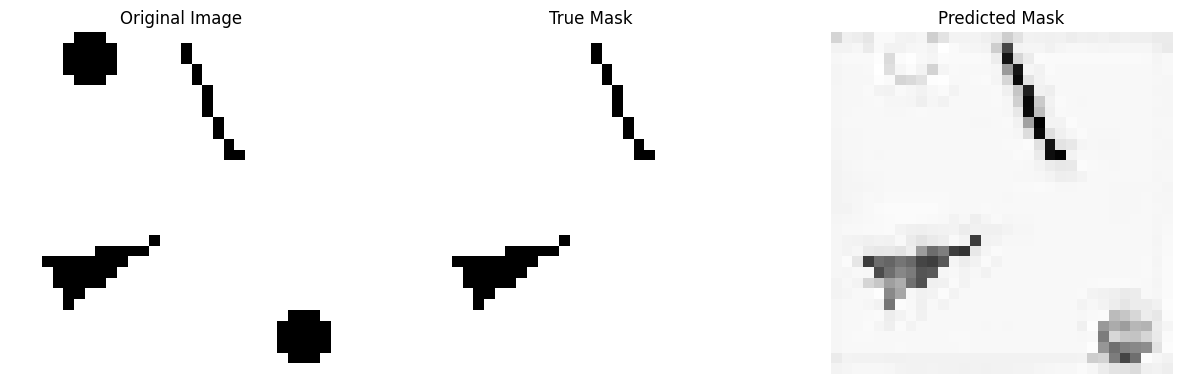

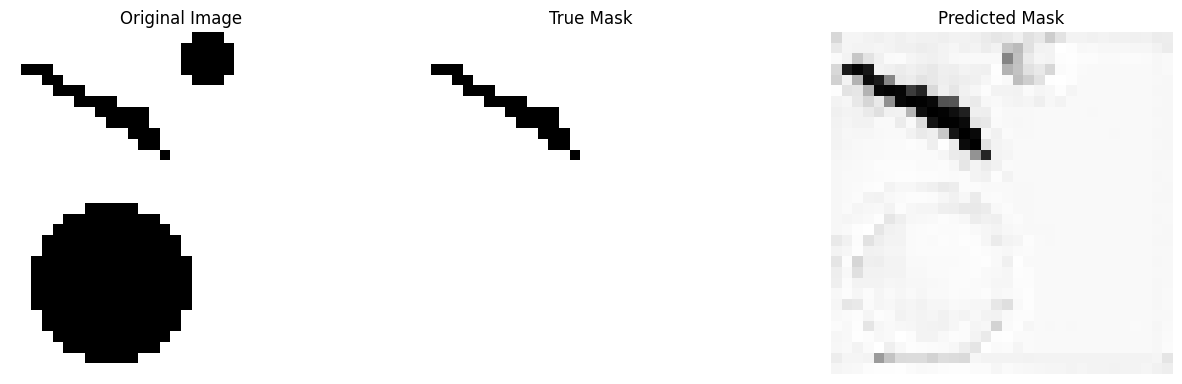

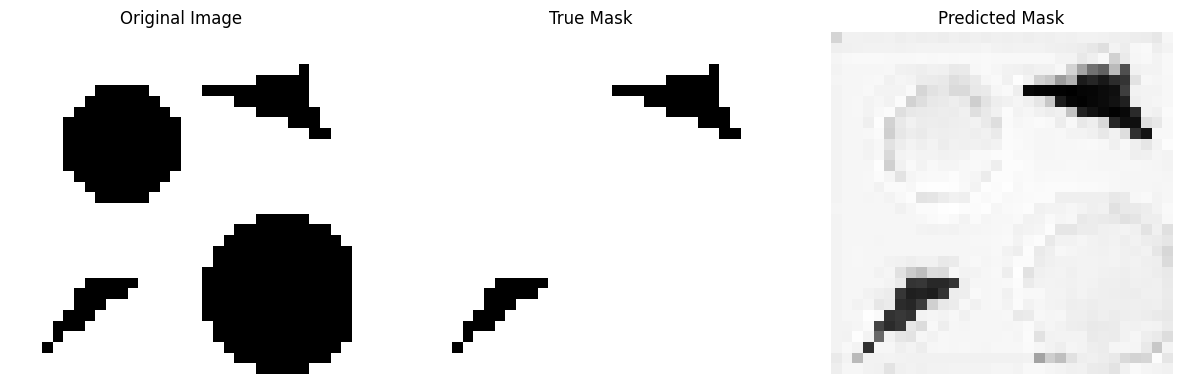

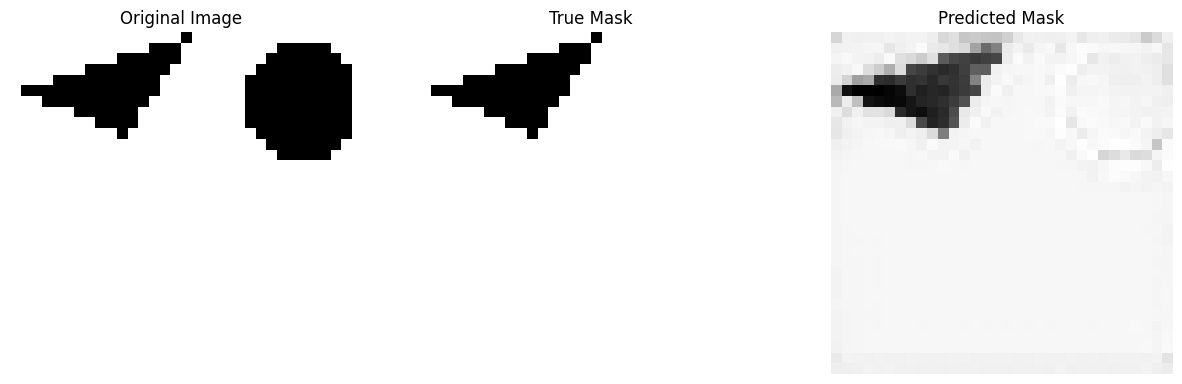

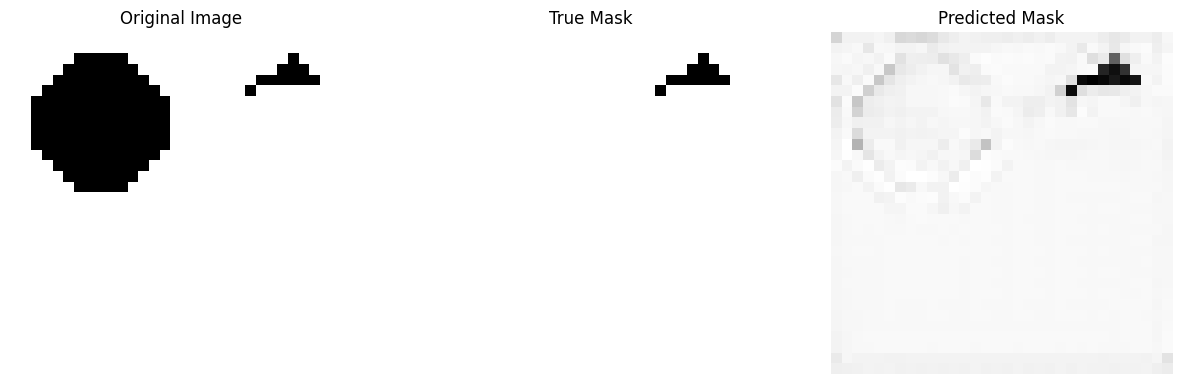

In [23]:
# Pick an example from the test dataset
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, true_masks in test_loader:
        images = images.to(device)
        true_masks = true_masks.to(device)

        # Get the model prediction
        predicted_masks = model(images)

        # Convert tensors to CPU and detach them for plotting
        images = images.cpu().detach().numpy()
        true_masks = true_masks.cpu().detach().numpy()
        predicted_masks = predicted_masks.cpu().detach().numpy()

        # Plot the first image, true mask, and predicted mask
        plot_image_mask_prediction(images[0], true_masks[0], predicted_masks[0])
        # break  # Only plot for the first batch, remove break to plot more